In [ ]:
!pip install sklearn

In [ ]:
import torch
import numpy as np
from sklearn.utils import shuffle
from matplotlib import pyplot as plt

#Multi-class Logistic Regression 


---

>The MNIST label set consists of ten possible digits. 
Multi-class model is used to determine the linear score $(w_t \cdot x)$ of the corresponding digit $y$.


In [ ]:
# hyperparameters for a classifier
threshold = 120
num_iter = 20
learning_rate = 0.001
reg_factor = 0.6

In [ ]:
"""
Read data from the specified training, validation and test data files.
"""


def read_data(trainFile, valFile, testFile):
    features = []
    labels = []

    # read training, test, and validation data
    for file in [trainFile, valFile, testFile]:
        # read data
        data = np.loadtxt(file)

        # transform into our feature space with "fe()"
        features.append(fe(torch.tensor(data[:, :-1])))

        labels.append(torch.tensor(data[:, -1]))

    return features[0], labels[0], features[1], \
        labels[1], features[2], labels[2]

In [ ]:
"""
Feature that counts the number of pixels above a specified threshold
in each row and column.
"""

def fe(X):
    # get a "binary image" indicator of pixels above and below the threshold
    X_binary = torch.where(X > threshold,
                           torch.ones_like(X), torch.zeros_like(X)).reshape(-1, 28, 28)
    
    # calculate row and column features
    X_row = X_binary.sum(dim=1)
    X_col = X_binary.sum(dim=2)

    # include a row of ones at the end for bias
    return torch.cat([X_row, X_col, torch.ones(X_row.shape[0],
                                               1, dtype=torch.float64)], dim=1)

In [ ]:
"""
Convert "y" into its one-hot-encoding equivalent.
"""
def one_hot(y):
    y_one_hot = torch.zeros([y.shape[0], 10], dtype=torch.float64)
    return y_one_hot.scatter(1, y.reshape(-1, 1).to(torch.long), 1)

In [ ]:
"""
Get the scores for each class for each training point.
"""

def get_scores(X, w):
    return torch.mm(X,w.T)

# Train

---

 >The conditional probability of the digit label, $y$, given the image feature vector, $x$, when using this model class can be written as:
$
P_w(y|x) = \frac{\exp (w_y \cdot x)}{\sum_{y'} \exp (w_{y'} \cdot x)}$

> The Loss function with L2 regularization can be written as: 
$ L(w) = -\sum_{i=1}^n \ln P_w(y|x) + \ \lambda \|w\|^2 = \sum_{i=1}^n \ln \frac{\sum_{y'} \exp (w_{y'} \cdot x)}{\exp (w_{y'} \cdot x)} + \ \lambda \|w\|^2 $


In [ ]:
def train(X, y):
    # convert index labels of y into a one-hot encoding
    label = y.long()
    one_hot_y = one_hot(y)
    # loss list over iterations for plotting
    losses = []
    batch_size = 20
    n_iter = 100
    # initialize model weights
    w = torch.rand((10, X.shape[1]), dtype=torch.float64, requires_grad=True)
    i = 0
    loss_func = torch.nn.CrossEntropyLoss()
    
    X, label = shuffle(X, label)
    while i < num_iter:
            for rep in range(n_iter):
                
                x_train = X[rep*batch_size : (rep+1) * batch_size]
                y_train = label[rep*batch_size : (rep+1) * batch_size]
                input = get_scores(x_train,w)
                loss = loss_func(input,y_train) + reg_factor * torch.sum(w ** 2)
                
                # calculate loss gradient
                loss.backward()

                # save for plotting
                losses.append(loss.item())
                
                with torch.no_grad():
                    w.sub_(learning_rate * w.grad)
                w.grad.data.zero_()

            i += 1
    
    return w, losses

In [ ]:
"""
Get list of predicted labels for feature set "X" using model 
parameterized by w.
"""
def predict(X, w):
    # get scores for each class for each input
    scores = get_scores(X, w)

    # find the index of the maximum score for each input,
    # which happens to exactly correspond to the label!
    return torch.argmax(scores, dim=1)

tensor(701)
Validation accuracy: 0.701


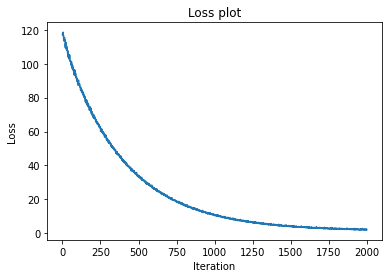

In [ ]:
"""
Evaluate the model parameterized by "w", using unseen data features "X" and
corresponding labels "y".
"""
def evaluate(X, y, w):
    # use model to get predictions
    predictions = predict(X, w)

    # total number of items in dataset
    total = y.shape[0]

    # number of correctly labeled items in dataset
    correct = torch.sum(predictions == y.long())
    
    print(correct)
    # return fraction of correctly labeled items in dataset
    return float(correct) / float(total)

if __name__ == "__main__":
    # load data from file
    train_vec, train_lab, val_vec, val_lab, test_vec, test_lab \
        = read_data('hw0train.txt', 'hw0validate.txt', 'hw0test.txt')
    
    # find w through gradient descent
    w, losses = train(train_vec, train_lab)
    # evaluate model on validation data
    accuracy = evaluate(val_vec, val_lab, w)
    
    print("Validation accuracy: {}".format(accuracy))

    # plot losses
    plt.plot(losses)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Loss plot")
    plt.show()